# AFIT Wrapped 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import re
import seaborn as sns
import datetime

from random import choice
from tqdm import tqdm
from IPython.display import Markdown as md

color_pairs = [
    ('#E2D1F9', '#317773'), # lavender and teal
    ('#CCF381', '#4831D4'), # lime and blue
    ('#2C5F2D', '#97BC62FF'), # forest green and moss green
    ('#FFE77AFF', '#2C5F2DFF'), #  yellow and green
    ('#435E55FF', '#D64161FF'), # green and raspberry  
]

def rand_color_pair():
    return choice(color_pairs)

def rand_color():
    return choice(rand_color_pair())

font_prop = FontProperties(fname="./fonts/FontsFree-Net-CircularStd-Bold.ttf")
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
# Parse the conversation. First into lines
# convo_fname = 'convo.txt'
# with open(convo_fname, 'r') as f:
#     lines = f.readlines()
#     lines = [line.strip() for line in lines]

# df = pd.DataFrame(columns=['date', 'time', 'author', 'message'])

# for line in tqdm(lines):
#     # 11/04/2022, 13:09 - Fco: jajajajajjajajjajajajajaja

#     if line.startswith('['):
#         continue
#     try:
#         date = re.search(r'\d{2}/\d{2}/\d{4}', line).group()
#         time = re.search(r'\d{2}:\d{2}', line).group()
#         author = re.search(r'(?<=- )\w+', line).group()
#         message = re.search(r'(?<=: ).*', line).group()
#     except:
#         continue

#     row = pd.DataFrame([[date, time, author, message]], columns=['date', 'time', 'author', 'message'])
#     df = pd.concat([df, row], ignore_index=True)


In [3]:
# df.to_csv('convo.csv', index=False)
df = pd.read_csv('convo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79998 entries, 0 to 79997
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     79998 non-null  object
 1   time     79998 non-null  object
 2   author   79998 non-null  object
 3   message  79575 non-null  object
dtypes: object(4)
memory usage: 2.4+ MB


In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time
df['message'] = df['message'].fillna('')
df['n_words'] = df['message'].apply(lambda x: len(x.split()))

In [5]:
# Print column types of first elem in
for col in df.columns:
    print(col, type(df[col][0]))

date <class 'pandas._libs.tslibs.timestamps.Timestamp'>
time <class 'datetime.time'>
author <class 'str'>
message <class 'str'>
n_words <class 'numpy.int64'>


In [6]:
df.head()

,date,time,author,message,n_words
0,2022-04-11,13:05:00,Andrea,tengo ganas de que pruebes la otra tosta de la...,11
1,2022-04-11,13:05:00,Fco,digo el popper en el centro que como que no pe...,11
2,2022-04-11,13:05:00,Fco,anda que noo,3
3,2022-04-11,13:06:00,Fco,no me vistee,3
4,2022-04-11,13:06:00,Andrea,ahhhhhh,1


In [7]:
users = df['author'].unique()
print(users)

['Andrea' 'Fco']


In [8]:
# First day of the chat and last day of the chat
first_day = df['date'].min().strftime('%d/%m/%Y')
last_day = df['date'].max().strftime('%d/%m/%Y')

md(f"Hemos recogido todos los mensajes comprendidos entre el {first_day} y el {last_day}. Por motivos de WhatsApp, no podemos acceder a los mensajes anteriores a esa fecha.")

Hemos recogido todos los mensajes comprendidos entre el 11/04/2022 y el 31/12/2022. Por motivos de WhatsApp, no podemos acceder a los mensajes anteriores a esa fecha.

In [9]:
def week_date(week_number, year):
    """Returns a datetime indicating the first day of the given week number"""
    d = datetime.date(year, 1, 1)
    if(d.weekday() > 3):
        d = d + datetime.timedelta(7-d.weekday())
    else:
        d = d - datetime.timedelta(d.weekday())
    dlt = datetime.timedelta(days = (week_number-1)*7)
    return d + dlt

/tmp/ipykernel_29410/799151401.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  aux['week'] = aux['date'].dt.week
/tmp/ipykernel_29410/799151401.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aux_grouped = aux.groupby(['week']).sum().reset_index()


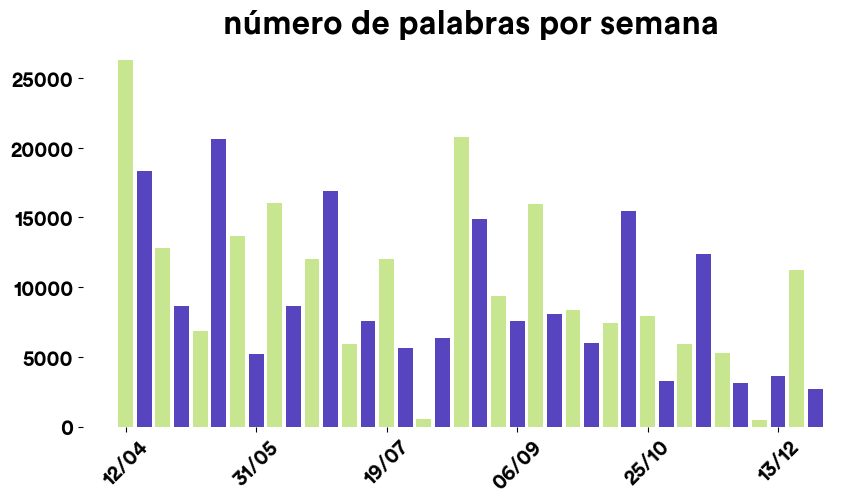

In [10]:
aux = df.copy()
aux['week'] = aux['date'].dt.week
aux_grouped = aux.groupby(['week']).sum().reset_index()

sns.barplot(x='week', y='n_words', data=aux_grouped, palette=rand_color_pair())
plt.title('número de palabras por semana')

min_week = aux_grouped['week'].min()
max_week = aux_grouped['week'].max()

weeks = [week_date(week, 2021) for week in range(min_week, max_week+1)]
weeks = [week.strftime('%d/%m') for week in weeks]

plt.xticks(range(len(weeks)), weeks, rotation=45)
plt.locator_params(axis='x', nbins=6)
plt.xlabel('')
plt.ylabel('')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


## ¿Cuántos palabras ha enviado cada uno?

/tmp/ipykernel_29410/3384936142.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aux_grouped = aux.groupby(['author']).sum().reset_index()


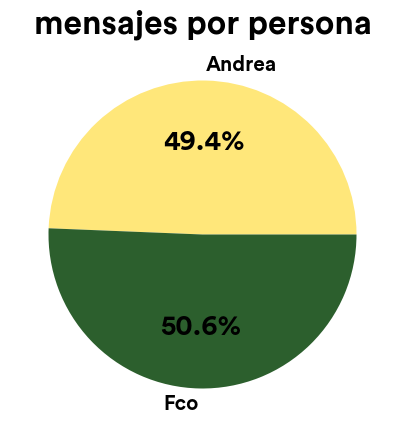

In [11]:
aux = df.copy()
aux['n_messages'] = 1
aux_grouped = aux.groupby(['author']).sum().reset_index()

more_msgs = aux_grouped['n_messages'].max()
more_msgs_author = aux_grouped[aux_grouped['n_messages'] == more_msgs]['author'].values[0]

plt.pie(aux_grouped['n_messages'], labels=aux_grouped['author'], autopct='%1.1f%%', colors=rand_color_pair())
plt.title('mensajes por persona')
plt.show()

## ¿Cuántas palabras ha escrito cada uno?

/tmp/ipykernel_29410/279054657.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aux_grouped = aux.groupby(['author']).sum().reset_index()


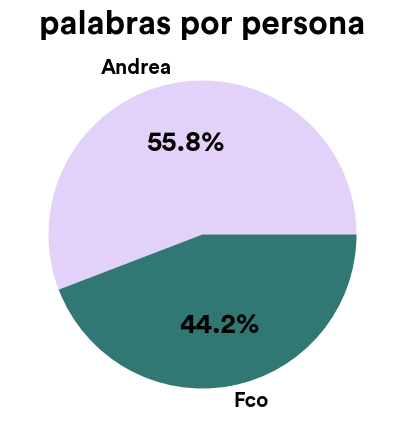

In [12]:
aux = df.copy()
aux['n_words'] = aux['message'].apply(lambda x: len(x.split()))
aux_grouped = aux.groupby(['author']).sum().reset_index()

more_words = aux_grouped['n_words'].max()
more_words_author = aux_grouped[aux_grouped['n_words'] == more_words]['author'].values[0]

plt.pie(aux_grouped['n_words'], labels=aux_grouped['author'], autopct='%1.1f%%', colors=rand_color_pair())
plt.title('palabras por persona')
plt.show()

/tmp/ipykernel_29410/4261415544.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aux_grouped = aux.groupby(['author']).sum().reset_index()


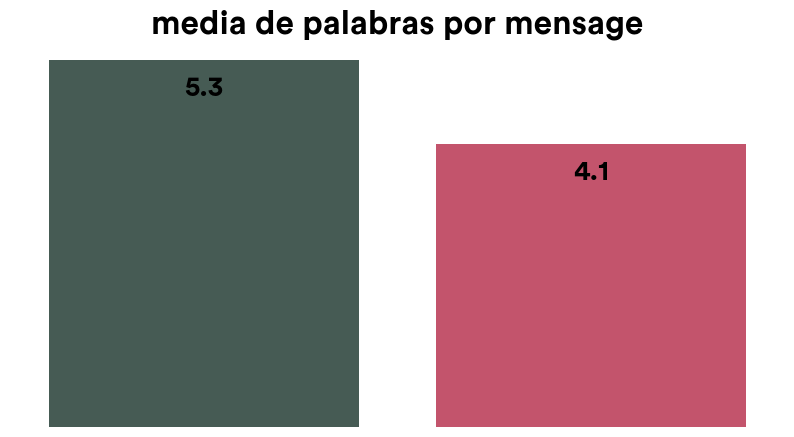

In [13]:
# Media de palabras por mensaje por usuario. 

aux = df.copy()
aux['n_words'] = aux['message'].apply(lambda x: len(x.split()))
aux['n_messages'] = 1
aux_grouped = aux.groupby(['author']).sum().reset_index()

aux_grouped['avg_words'] = aux_grouped['n_words'] / aux_grouped['n_messages']

sns.barplot(x='author', y='avg_words', data=aux_grouped, palette=rand_color_pair())
plt.title('media de palabras por mensage')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False)

# for p in splot.patches:
#     splot.annotate(format(p.get_height(), '.1f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    size=15,
#                    xytext = (0, -12), 
#                    textcoords = 'offset points')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=20,
                   xytext = (0, -20), 
                   textcoords = 'offset points')

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()


## ¿Cuánto hablamos....

### ...por día?

/tmp/ipykernel_29410/3900657021.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aux_grouped = aux.groupby(['weekday', 'author']).sum().reset_index()


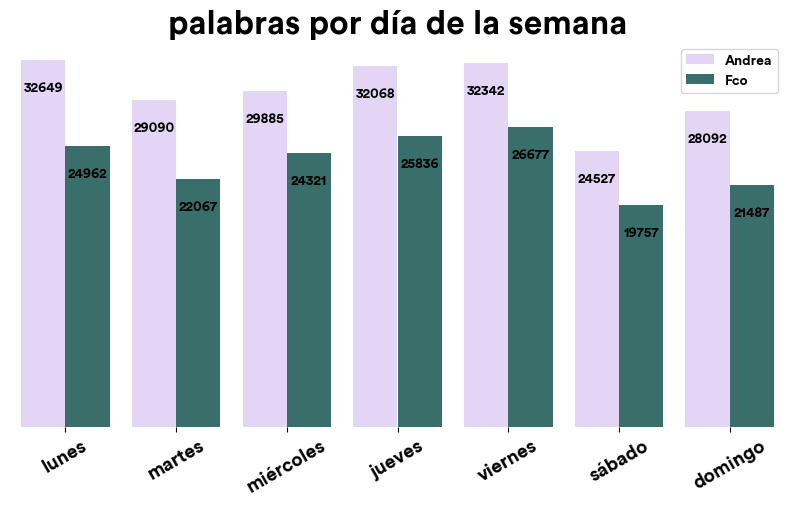

In [14]:
aux = df.copy()
aux['n_words'] = aux['message'].apply(lambda x: len(x.split()))
aux['weekday'] = aux['date'].dt.day_name()
aux_grouped = aux.groupby(['weekday', 'author']).sum().reset_index()

aux_grouped['weekday'] = pd.Categorical(aux_grouped['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
aux_grouped['weekday'] = aux_grouped['weekday'].apply(lambda x: x
    .replace('Monday', 'lunes')
    .replace('Tuesday', 'martes')
    .replace('Wednesday', 'miércoles')
    .replace('Thursday', 'jueves')
    .replace('Friday', 'viernes')
    .replace('Saturday', 'sábado')
    .replace('Sunday', 'domingo'))

sns.barplot(x='weekday', y='n_words', hue='author', data=aux_grouped, palette=rand_color_pair())
plt.title('palabras por día de la semana')
plt.xlabel('')
plt.ylabel('')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_legend().set_title(None)
ax.get_legend().get_frame().set_linewidth(0.0)
plt.legend(fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -20), 
                   textcoords = 'offset points')
plt.xticks(rotation=30, size=14)
plt.yticks([])

plt.show()


### ...y por hora?

/tmp/ipykernel_29410/85742093.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aux_grouped = aux.groupby(['hour', 'author']).sum().reset_index()


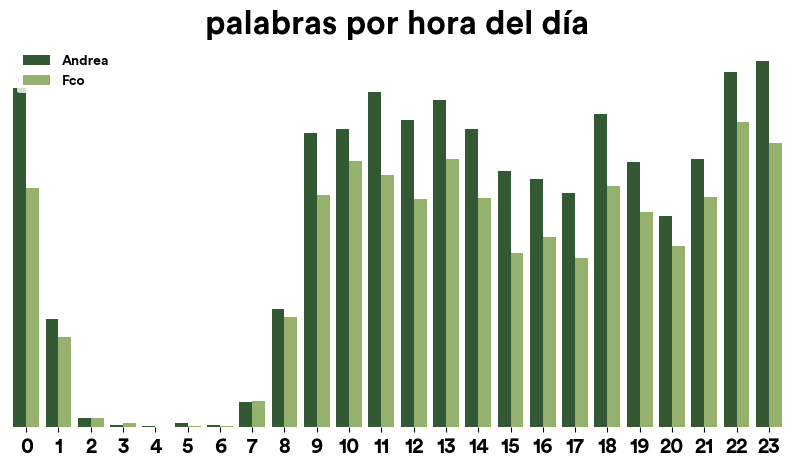

In [15]:
aux = df.copy()
aux['n_words'] = aux['message'].apply(lambda x: len(x.split()))
aux['hour'] = aux['time'].apply(lambda x: x.hour)
aux_grouped = aux.groupby(['hour', 'author']).sum().reset_index()

sns.barplot(x='hour', y='n_words', hue='author', data=aux_grouped, palette=rand_color_pair())
plt.title('palabras por hora del día')
plt.xlabel('')
plt.ylabel('')
plt.xticks(range(24), range(24))
plt.yticks([])
plt.legend(fontsize=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_legend().set_title(None)
ax.get_legend().get_frame().set_linewidth(0.0)

plt.show()
